<a href="https://colab.research.google.com/github/peterjsadowski/keras_tutorial/blob/master/2_keras_mnist_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Keras Tutorial
This tutorial introduces:

1. Using the GPU
2. Data generators in Keras.
3. Functional API for complex models.

The goal is to take two images of digits, and add them together. The model is never trained to recognize individual digits, but must learn this in order to solve the more complex problem.



In [1]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import os, sys, socket

import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, Conv2D, Flatten
from keras.layers import Concatenate
from keras.optimizers import SGD, Adam

## Define data generators for training and validation.

In [31]:
# The following function is used to serve up both train and validation data.
# Define a custom data generator class
class CustomDataGenerator(keras.utils.PyDataset):
    def __init__(self, X, Y, batchsize):
        self.X = X
        self.Y = Y
        self.batchsize = batchsize

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.ceil(len(self.X) / self.batchsize))

    def __getitem__(self, index):
        # Generate data for a single batch
        N = self.X.shape[0]
        indices1 = np.random.randint(low=0, high=N, size=(self.batchsize,))
        indices2 = np.random.randint(low=0, high=N, size=(self.batchsize,))

        X1 = self.X[indices1,...].astype('float32') / 255.0
        X2 = self.X[indices2,...].astype('float32') / 255.0
        Y1 = self.Y[indices1]
        Y2 = self.Y[indices2]
        T  = (Y1 + Y2) # Sum of values.

        X1 = np.expand_dims(X1, axis=1) # For conv with theano, shape=(batchsize, channels, row, col).
        X2 = np.expand_dims(X2, axis=1) # We are just adding a dummy dimension saying that there is one channel.

        Y1 = keras.utils.to_categorical(Y1, 10)
        Y2 = keras.utils.to_categorical(Y2, 10)
        T  = keras.utils.to_categorical(T, 19) # 19 possible values.

        return {'input1':X1 , 'input2':X2},  {'out':T}



def data_generator(X, Y, batchsize):
    nb_classes = 10
    N = X.shape[0]
    while True:
        indices1 = np.random.randint(low=0, high=N, size=(batchsize,))
        indices2 = np.random.randint(low=0, high=N, size=(batchsize,))

        X1 = X[indices1,...].astype('float32') / 255.0
        X2 = X[indices2,...].astype('float32') / 255.0
        Y1 = Y[indices1]
        Y2 = Y[indices2]
        T  = (Y1 + Y2) # Sum of values.

        X1 = np.expand_dims(X1, axis=1) # For conv with theano, shape=(batchsize, channels, row, col).
        X2 = np.expand_dims(X2, axis=1) # We are just adding a dummy dimension saying that there is one channel.

        Y1 = keras.utils.to_categorical(Y1, nb_classes)
        Y2 = keras.utils.to_categorical(Y2, nb_classes)
        T  = keras.utils.to_categorical(T, 19) # 19 possible values.

        yield {'input1':X1 , 'input2':X2}, T #  {'out':T} #, 'aux1':Y1, 'aux2':Y2}

# Load data.
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data() # Shape = (N,28,28), (N,)
# Create generators.
batchsize  = 200
data_train = CustomDataGenerator(X_train, Y_train, batchsize)
data_valid = CustomDataGenerator(X_valid, Y_valid, batchsize)

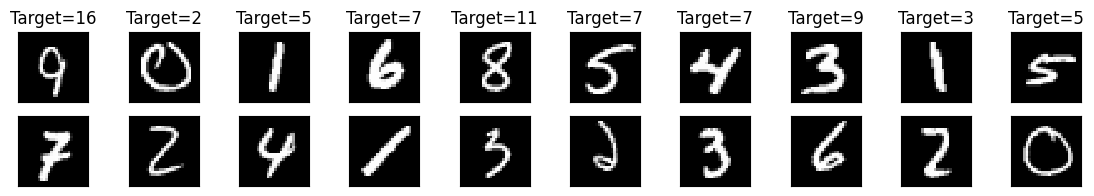

In [32]:
# Plot examples of the data.
inputs, outputs = data_train.__getitem__(index=0)
Xbatch = inputs['input1']
plt.figure(1, figsize=(14,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(inputs['input1'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('Target=%d' % np.argmax(outputs['out'][i]))
    plt.subplot(2,10,10+i+1)
    plt.imshow(inputs['input2'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# Define Keras Model with the Functional API


In [4]:
# Input data.
input1   = Input(shape=(1, 28,28), dtype='float32', name='input1') # Argument 'name' must match name in dictionary.
input2   = Input(shape=(1, 28,28), dtype='float32', name='input2')

# Layer one: Single convolutional layer applied to each input independently, with "shared weights."
nb_filter      = 32     # Number of convolutional kernels.
nb_row, nb_col = 7,7   # Convolution kernel size.
strides        = (3,3) # Step size for convolution kernels.
conv  =  Conv2D(nb_filter, (nb_row, nb_col), activation='relu', padding='same', strides=strides)
x1    = conv(input1) # Layer object conv transforms data.
x2    = conv(input2)

# Flatten data: transform from (28,28) to (784,)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

# Layer two: Single fully-connected layer applied to each input independently, with shared weights.
layer = Dense(256, activation='relu')
x1 = layer(x1)
x2 = layer(x2)

# Auxiliary softmax layers try to classify digits.
# The output of these layers aren't fed into the next layer.
#layer = Dense(10) # These weights are shared.
#aux1  = Activation(activation='softmax', name='aux1')(layer(x1)) # Output layers must be named.
#aux2  = Activation(activation='softmax', name='aux2')(layer(x2))

# Merge hidden representations.
#x = merge.Concatenate()([x1, x2])
x = Concatenate()([x1, x2])

# More dense layers then output.
x   = Dense(512, activation='relu')(x)
out = Dense(19, activation='softmax', name='out')(x) # Output layers must be named.

# Create model object that puts it all together.
#model = Model(inputs=[input1, input2], outputs=[out, aux1, aux2])
model = Model(inputs=[input1, input2], outputs=[out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)       │ (None, 1, 28, 28)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input2 (InputLayer)       │ (None, 1, 28, 28)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1, 10, 32)      │         43,936 │ input1[0][0],          │
│                           │                        │                │ input2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 320)            │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 320)            │              0 │ conv2d[1][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         82,176 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out (Dense)               │ (None, 19)             │          9,747 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 398,515 (1.52 MB)

 Trainable params: 398,515 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

# Optimization

In [33]:
optimizer = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy'},
              loss_weights=1.0, #{'out': 1.0}, #
              metrics=['accuracy'])


## Train the model.

In [34]:
# Callbacks can be used to stop early, decrease learning rate, checkpoint the model, etc.
#from keras.callbacks import EarlyStopping
#stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
callbacks = []#[stopping]

# The fit_generator function loads data batches on the fly, instead of transfering entire data set to the gpu.
history   = model.fit(x=data_train,
                      steps_per_epoch=100, # 500
                      epochs=10, verbose=1,
                      callbacks=callbacks,
                      validation_data=data_valid, validation_steps=100)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1196 - loss: 2.6684 - val_accuracy: 0.2550 - val_loss: 2.0819
Epoch 2/10
 47/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2727 - loss: 2.0343

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3082 - loss: 1.9477 - val_accuracy: 0.5294 - val_loss: 1.4334
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6009 - loss: 1.2495 - val_accuracy: 0.7727 - val_loss: 0.7785
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7721 - val_loss: 0.7798
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7995 - loss: 0.6946 - val_accuracy: 0.8573 - val_loss: 0.4979
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8605 - loss: 0.4823 - val_accuracy: 0.8952 - val_loss: 0.3597
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8971 - loss: 0.3610 - val_accuracy: 0.9177 - val_loss: 0.2779
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9169 - val_loss: 0.2795
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9247 - loss: 0.2601 - val_accurac

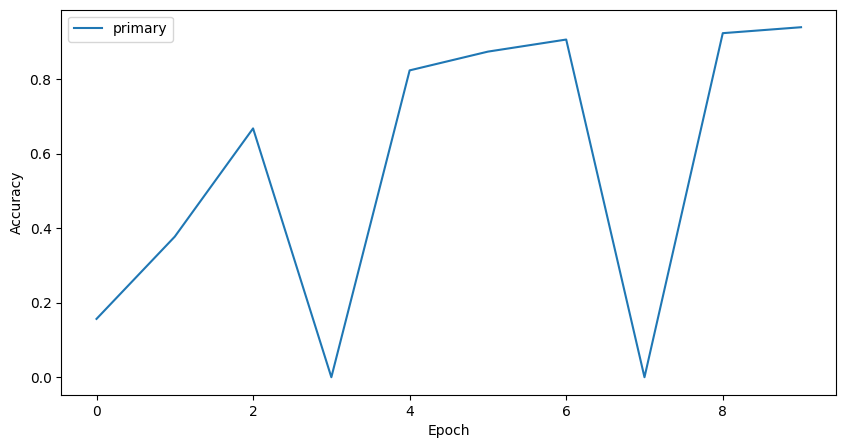

In [35]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(10,5))
plt.plot(history.history['accuracy'], label='primary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Post-training analysis.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


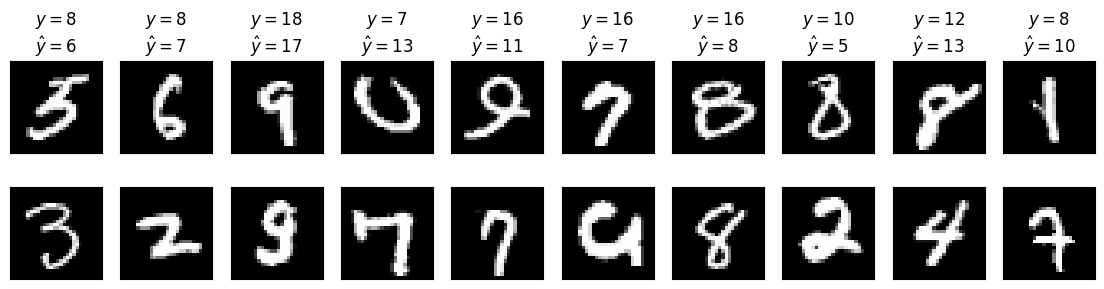

In [38]:
# Plot example pairs for which the network made a mistake.
inputs, outputs = data_valid.__getitem__(index=0)
plt.figure(1, figsize=(14,3))
i = 0
while i < 10:
    inputs, outputs = data_valid.__getitem__(index=0)
    predictions = model.predict(inputs)
    j = 0
    while j < 100:
        yhat   = predictions[j].argmax(axis=-1) # predictions is list: [out, aux1, aux2]
        y      = np.argmax(outputs['out'][j])
        input1 = inputs['input1'][j].reshape(28,28)
        input2 = inputs['input2'][j].reshape(28,28)
        j += 1
        if yhat == y:
            # Prediction was correct. Ignore this example.
            continue
        else:
            # Prediction was incorrect. Show example.
            plt.subplot(2,10,i+1)
            plt.imshow(input1, cmap='gray', interpolation='nearest')
            plt.xticks([])
            plt.yticks([])
            plt.title('Pred=%d' % yhat)
            plt.title('$y=%d$\n$\hat{y}=%d$' % (y,yhat))
            plt.subplot(2,10,10+i+1)
            plt.imshow(input2, cmap='gray', interpolation='nearest')
            plt.xticks([])
            plt.yticks([])
            i += 1
        if not i<10:
            break
